In [ ]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),  # Remove the auxiliary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_

In [ ]:
MODEL_NAME = 'MNISTGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [ ]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x) # input includes labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.392045259475708, G Loss: -0.6734704375267029
Epoch: 0/10, Step: 500, D Loss: 1.248068928718567, G Loss: -0.5867395997047424
Epoch: 1/10, Step: 1000, D Loss: 1.4120395183563232, G Loss: -0.5922015309333801
Epoch: 1/10, Step: 1500, D Loss: 1.2213068008422852, G Loss: -0.6401869654655457
Epoch: 2/10, Step: 2000, D Loss: 1.2362632751464844, G Loss: -0.5105670690536499
Epoch: 2/10, Step: 2500, D Loss: 1.1513545513153076, G Loss: -0.7623332142829895
Epoch: 3/10, Step: 3000, D Loss: 1.0750434398651123, G Loss: -0.5743759870529175
Epoch: 3/10, Step: 3500, D Loss: 1.1049013137817383, G Loss: -0.5375596284866333
Epoch: 4/10, Step: 4000, D Loss: 1.2095980644226074, G Loss: -0.6221669316291809
Epoch: 4/10, Step: 4500, D Loss: 1.2917771339416504, G Loss: -0.7716796398162842
Epoch: 5/10, Step: 5000, D Loss: 1.3224141597747803, G Loss: -0.7518049478530884
Epoch: 5/10, Step: 5500, D Loss: 1.2871267795562744, G Loss: -0.3553234338760376
Epoch: 6/10, Step: 6000, D Loss: 1

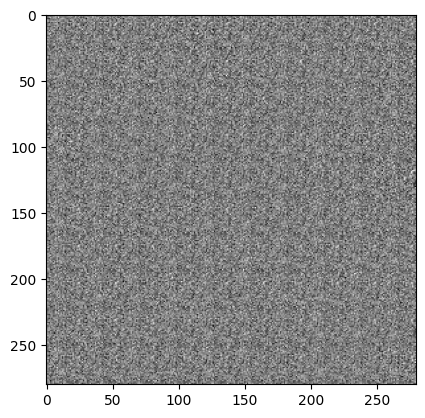

In [ ]:
img = mpimg.imread('samples/MNISTGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

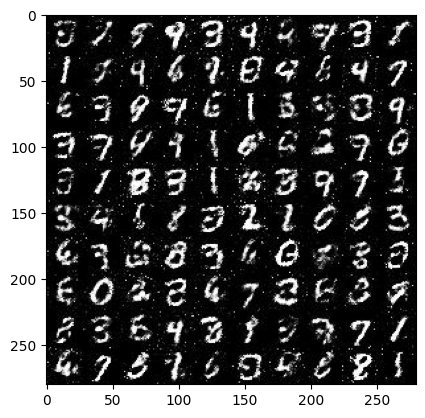

In [ ]:
img = mpimg.imread('samples/MNISTGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

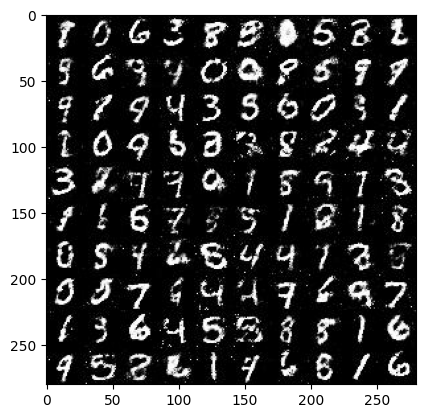

In [ ]:
img = mpimg.imread('samples/MNISTGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()